# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_27 08-05-24 Deep Neural Network asian options


In [2]:
model = models[0]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_27 08-05-24 Deep Neural Network asian options insample.csv
1     2024_10_27 08-05-24 Deep Neural Network asian options outsample.csv
2     2024_10_27 08-05-24 Deep Neural Network asian options.pkl
3     2024_10_27 08-05-24 Deep Neural Network asian options.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('insample')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('outsample')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))
print('maturities:',np.sort(test_data['days_to_maturity'].unique()))
print(model_fit)

maturities: [  1   7  28  84 168 336]
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                            

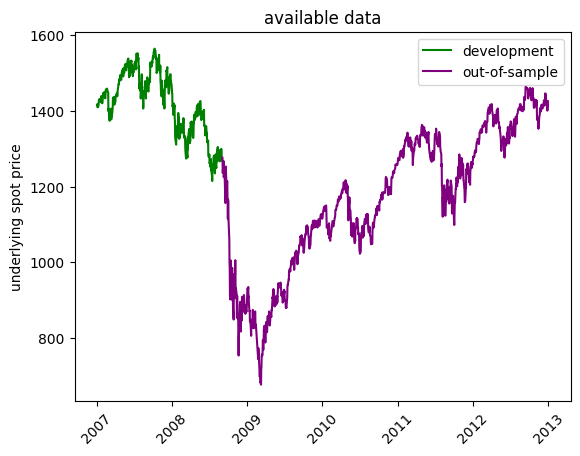

458220


In [4]:
train_spots = train_data['spot_price']
test_spots = test_data['spot_price']
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
print(test_data.shape[0])

In [5]:
diff = test_data['outofsample_error'].copy()
def compute_RMSE(diff):
    return np.sqrt(np.mean(diff**2))
def compute_MAE(diff):
    return np.mean(np.abs(diff))
test_data['RMSE'] = diff.resample('D').apply(compute_RMSE).dropna()
test_data['MAE'] = diff.resample('D').apply(compute_MAE).dropna()
regression_data = test_data[
    [
        'spot_price',
        'theta', 
        'kappa',
        'rho',
        'eta', 
        'v0',
        'RMSE', 'MAE'
    ]
].copy().drop_duplicates()

# Testing

In [6]:
regression_data

,spot_price,theta,kappa,rho,eta,v0,RMSE,MAE
calculation_date,,,,,,,,
2008-09-02,1277.53,0.060409,2.129509,-1.000000,0.172868,0.040641,2.757522,1.789542
2008-09-03,1275.25,0.058609,2.693908,-1.000000,0.178095,0.038360,2.810832,1.781569
2008-09-04,1236.81,0.062183,1.521139,-1.000000,0.167885,0.050277,2.844644,1.781019
2008-09-05,1242.38,0.059311,2.859490,-1.000000,0.183520,0.044849,2.865858,1.795580
2008-09-08,1267.76,0.055250,3.372719,-0.735338,0.256952,0.043867,2.994667,1.907757
...,...,...,...,...,...,...,...,...
2012-12-24,1425.78,0.045075,1.533653,-0.758727,0.187296,0.021678,5.811224,3.491105
2012-12-26,1419.95,0.045965,1.502570,-0.631430,0.230292,0.024230,5.515436,3.396736
2012-12-27,1417.38,0.049897,1.254997,-0.471477,0.306944,0.026584,5.195527,3.311010


In [7]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

### testing for the effect of the spot level on pricing accuracy

In [8]:
regression_data.dtypes

spot_price    float64
theta         float64
kappa         float64
rho           float64
eta           float64
v0            float64
RMSE          float64
MAE           float64
dtype: object

### unrestricted regression

In [9]:
X = pd.DataFrame()
X['spot_price'] = regression_data['spot_price']
X[['theta', 'v0',]] = np.sqrt(regression_data[['theta', 'v0']])*100 
X['kappa'] = regression_data['kappa']
X['eta'] = regression_data['eta']*100

train_spots = train_data['spot_price'].drop_duplicates()
# train_spots, X.iloc[:,0] = np.log(train_data['spot_price'].drop_duplicates()),np.log(X.iloc[:,0])

target_name = 'RMSE'
y = regression_data[target_name].loc[X.index]
fit_intercept = False

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.xticks(rotation=45)
for column in X.columns[1:]:
    ax1.plot(X.index, X[column], label=column)
ax1.plot(X.index, y, label=target_name, color="black")
ax2.plot(X.index, X['spot_price'], label='out-of-sample', color="purple")
ax2.plot(train_spots,color='green',label='development')
ax2.set_ylabel("spot level")
ax1.legend(loc='lower left')
ax2.legend(loc="upper right")
plt.show()

KeyError: 'spot_/price'

In [ ]:
Ufit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
print(f"features:\n{X.dtypes}\n\ntarget: {target_name}\n")
for i,c in enumerate(Ufit.coef_):
    print(f"b{i}:   {c}")
print(f"intercept: {Ufit.intercept_}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"\nURSS: {URSS}")

### restricted regression

In [ ]:
X = X.iloc[:,1:]
Rfit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
print(f"features:\n{X.dtypes}\n\ntarget: {target_name}\n")
for i,c in enumerate(Rfit.coef_):
    print(f"b{i+1}:   {c}")
print(f"intercept: {Rfit.intercept_}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"\nRRSS: {RRSS}")

### F-Test

In [ ]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")